# Guess the ELO Transformer

In this notebook, we begin training a transformer to predict the ELO rating of 2 participants in a chess game given the move order. ELO ratings attempt to quantify and rank the ability of chess players; they are determined by the lichess ELO rating system (Glicko 2 rating system: https://lichess.org/page/rating-systems). 

We use games selected from a single month of the lichess open database (https://database.lichess.org/). Only rapid time control games are included. Data is stored in .pgn format, a standard file format for recording chess games. Each .pgn file contains information for multiple games. For each game in the .pgn file, we extract the ELO of the white and black player, the move order, given in algebraic notation (https://en.wikipedia.org/wiki/Algebraic_notation_(chess)) and the result of the game ("1-0" for white win, "1/2-1/2" for a draw, and "0-1" for black win) which is concatenated at the end of the move history. These are then written to a .csv file for easier processing.

We train a RoBERTa model from the Hugging Face library (https://huggingface.co/docs/transformers/index) on the bidirectional (dynamic) masked machine learning task in order to get an informative fixed size representation of the move history. To our knowledge, no existing transformer model exists which has been trained on a large corpus of chess games in algebraic notation, and so transfer learning is not available and training begins with a random initialization of weights. After completing training on the masked language model task, we fine-tune the model to solve the particular problem of predicting player elo ratings from move history. We organize our models in this way to mimic the organization of standard NLP applications, where a large pretraining step is done on the masked machine learning task, which is then fine-tuned for a particular use case.

In [1]:
import chess.pgn # For parsing pgn file
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot
import os, sys
import logging
import tqdm

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path

from transformers import Trainer
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import RobertaConfig, RobertaForMaskedLM, RobertaTokenizerFast
from transformers import Trainer, TrainingArguments
from datasets import Dataset

os.environ["WANDB_DISABLED"] = "true"

FORMAT = '%(asctime)s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

# Temp files for training
tokenizer_data = 'all_moves.txt'
transformer_data = 'mlm_training.txt'
model_dir = './inBERTnational_master'

num_games = 500#2000000 Actual training is done externally on first 2000000 games.
num_test = 100#20000
vocab_size = 2000
max_tokens=200
train_split = .9

## Data Parsing

Data is originally stored in .pgn format (standard format used for storing chess games). In this cell, we use pychess to parse the pgn file and extract the moves + result as a string and the ELO of the white and black player. The original Lichess pgn files are quite large (256 GB). This is too large for our current resources and is likely more data than needed, given that standard algebraic notation is a fairly constrained "language." We parse games until 1 GB of games are stored in a csv file to accommodate for our computational resources. 

In [2]:
def read_one_game_with_elos(game):
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]
    result = game.headers["Result"]
    board = chess.Board()
    move_history = board.variation_san(game.mainline_moves()).split()
    # Any strings ending in . are numbers i.e. 1. 2. 3. 4., ... these are just "grammar" and don't provide any additional information and so are removed.
    move_history = " ".join(mv for mv in move_history if not mv[-1] == ".")
    move_history += " " + result
    return move_history, white_elo, black_elo

# Downloaded from Lichess database linked above
large_pgn_file = '/media/sql/Samsung_T5/lichess_db_standard_rated_2021-03.pgn'
small_pgn_file_size = 1 # in GB
small_pgn_file = f'/home/sql/Documents/elo_guesser/data_file_{small_pgn_file_size}GB.csv'

In [57]:
with open(large_pgn_file) as large_pgn:
    with open(small_pgn_file, 'a') as small_pgn: 
        game = chess.pgn.read_game(large_pgn)
        while game is not None and os.path.getsize(small_pgn_file) < small_pgn_file_size * 1000000000:
            if all([head in game.headers for head in ['WhiteElo', 'BlackElo', 'Result','Event']]) and game.headers['Event']=='Rated Rapid game':
                move_history, white_elo, black_elo = read_one_game_with_elos(game)
                small_pgn.write(",".join([move_history, white_elo, black_elo]) + "\n")
            game = chess.pgn.read_game(large_pgn)

In [2]:
# Convert CSV to plain text for MLM
X = pd.read_csv('data_file_1GB.csv', sep=',', names = ['moves','white_elo', 'black_elo'])

logging.info(f'Number of games total: {X.shape[0]}')
# Used to train tokenizer
if os.path.exists(tokenizer_data):
    os.remove(tokenizer_data)
with open(tokenizer_data, 'a') as f:
    moves_as_str = X['moves']
    moves_as_str = moves_as_str.to_csv(sep='\n', header=False, index=False)
    f.write(moves_as_str)

# Used to train model
if os.path.exists(transformer_data):
    os.remove(transformer_data)
with open(transformer_data, 'a') as f:
    moves_as_str = X['moves'].iloc[:num_games]
    moves_as_str = moves_as_str.to_csv(sep='\n', header=False, index=False)
    f.write(moves_as_str)

2022-01-05 07:14:00,078 Number of games total: 3596879


### Tokenization

In [6]:
# Train a tokenizer for standard algebraic notation from scratch using Hugging Face libary
mlm_data_files = [tokenizer_data]

tokenizer = Tokenizer(BPE())
trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=["<s>", "</s>", "<mask>", "<pad>", "<unk>"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_truncation(max_length=max_tokens)
tokenizer.train(mlm_data_files, trainer)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
tokenizer.model.save(model_dir)

['./inBERTnational_master/vocab.json', './inBERTnational_master/merges.txt']

### Masked Language Model

We build a transformer to solve the (dynamic) masked language problem for the "language" of standard algebraic notation. This section makes large use of the Hugging Face library and in particular borrows code and ideas from the google colab notebook associated with this (https://huggingface.co/blog/how-to-train) blog post. We are unable to use pretrained Hugging Face models as standard algebraic notation is not a language for which a pretrained model exists.

It's worth noting that the amount of data here is very large; we have stored nearly 3.6 million games. As such the transformer takes fairly long to train, especially since we don't currently have access to a local gpu. Training is done in a google colab notebook seperately and the trained model will be available here. 12 hour runtime limits are bypassed by frequent checkpointing / restarting the colab kernel. Memory limits are bypassed by splitting the source text into multiple smaller text files and looping over these text files. These details of implementation complicate the code, though, and so are only shown in the colab notebook.

In [22]:
# First train RoBERTa for Masked Langauge Modelling to get a rich representation of input string.
config = RobertaConfig(
    vocab_size=vocab_size,
    max_position_embeddings=514,
    num_attention_heads=6,
    num_hidden_layers=3,
    type_vocab_size=1,
    num_labels=2,
)

tokenizer = RobertaTokenizerFast.from_pretrained(model_dir, max_len=max_tokens)
model = RobertaForMaskedLM(config=config)

dataset =  LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=transformer_data,
    block_size=128,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./trained_model",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=32,
    learning_rate=1e-4,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

trainer.train()
trainer.save_model(model_dir)

Didn't find file ./inBERTnational_master/tokenizer.json. We won't load it.
Didn't find file ./inBERTnational_master/added_tokens.json. We won't load it.
Didn't find file ./inBERTnational_master/special_tokens_map.json. We won't load it.
Didn't find file ./inBERTnational_master/tokenizer_config.json. We won't load it.
loading file ./inBERTnational_master/vocab.json
loading file ./inBERTnational_master/merges.txt
loading file None
loading file None
loading file None
loading file None
file ./inBERTnational_master/config.json not found
file ./inBERTnational_master/config.json not found
/home/sql/.pyenv/versions/3.9.0/envs/torch-3.9.0/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:121: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_m

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./inBERTnational_master
Configuration saved in ./inBERTnational_master/config.json
Model weights saved in ./inBERTnational_master/pytorch_model.bin


In [23]:
tokenizer = RobertaTokenizerFast.from_pretrained(model_dir, max_len=max_tokens)
model = RobertaForMaskedLM.from_pretrained(model_dir)

Didn't find file ./inBERTnational_master/tokenizer.json. We won't load it.
Didn't find file ./inBERTnational_master/added_tokens.json. We won't load it.
Didn't find file ./inBERTnational_master/special_tokens_map.json. We won't load it.
Didn't find file ./inBERTnational_master/tokenizer_config.json. We won't load it.
loading file ./inBERTnational_master/vocab.json
loading file ./inBERTnational_master/merges.txt
loading file None
loading file None
loading file None
loading file None
loading configuration file ./inBERTnational_master/config.json
Model config RobertaConfig {
  "_name_or_path": "./inBERTnational_master",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "r

### Fine-Tuning

We fine-tune the standard algebraic notation masked language model to the particular problem of predicting elo ratings of participating players. This is done similarly to as before, with the only 2 differences:

The data now also contains elo ratings of the 2 players under the "targets" key.

The objective is a simple L2 loss of predicted player ratings.

Hugging Face provides a RobertaForSequenceClassification wrapper, which can also be used for regression by setting config.num_labels to 1. However, we need to perform multi-target regression, so the provided class must be modified. This is done in the cell below, which is very similar to the RobertaForSequenceClassification class, but tweaks the relevant lines to allow for multi-target regression. 

In [3]:
sys.path.append(".")

from transformers import BertPreTrainedModel, RobertaModel
from guess_elo import RobertaForSequenceMultiTargetRegression # Custom Transformer Head
    
# The loss function is changed by redefining the compute_loss() function in the Trainer class.
class MultiTargetTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        targets = inputs['targets']
        outputs = model(**inputs)
        preds = outputs[1]
        loss_fct = nn.MSELoss()
        loss = loss_fct(preds.view(-1, self.model.config.num_labels),
                        targets.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [7]:
def compute_metrics(pred):
    truth = pred.label_ids
    preds = pred.predictions
    L2 = sklearn.metrics.mean_squared_error(truth, preds)
    return { "loss": L2
    }

tokenizer = RobertaTokenizerFast.from_pretrained('./inBERTnational_master_full', max_len=max_tokens-1)
model = RobertaForSequenceMultiTargetRegression.from_pretrained('./inBERTnational_master_full')

data_dict = {'moves': X['moves'].iloc[:num_games], 'targets': X[['white_elo', 'black_elo']].iloc[:num_games].values}
all_data =  Dataset.from_dict(data_dict)
train_data = Dataset.from_dict(all_data[:int(train_split * num_games)])
test_data = Dataset.from_dict(all_data[int(train_split * num_games):])

def tokenization(batched_text):
    return tokenizer(batched_text['moves'], padding = True, truncation=True)

train_data = train_data.map(tokenization, batched = True, batch_size = len(train_data))
test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))

train_data.set_format('torch', columns=['attention_mask', 'input_ids', 'moves', 'targets'])
test_data.set_format('torch', columns=['attention_mask', 'input_ids', 'moves', 'targets'])

training_args = TrainingArguments(
    output_dir = './finetuned_model',
    num_train_epochs=1,
    per_device_train_batch_size = 32,
    gradient_accumulation_steps = 1,    
    per_device_eval_batch_size= 32,
    evaluation_strategy = "steps",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    save_steps=500,
    eval_steps=500,
    weight_decay=0.01,
    save_strategy = "steps",
    dataloader_num_workers = 8,
    label_names=['targets'],
    run_name = 'roberta-regression'
)

trainer = MultiTargetTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data
)

trainer.train()
trainer.save_model('./finetuned_model')

Didn't find file ./inBERTnational_master_full/tokenizer.json. We won't load it.
Didn't find file ./inBERTnational_master_full/added_tokens.json. We won't load it.
Didn't find file ./inBERTnational_master_full/special_tokens_map.json. We won't load it.
Didn't find file ./inBERTnational_master_full/tokenizer_config.json. We won't load it.
loading file ./inBERTnational_master_full/vocab.json
loading file ./inBERTnational_master_full/merges.txt
loading file None
loading file None
loading file None
loading file None
loading configuration file ./inBERTnational_master_full/config.json
Model config RobertaConfig {
  "_name_or_path": "./inBERTnational_master_full",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_posit

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceMultiTargetRegression.forward` and have been ignored: moves.
***** Running training *****
  Num examples = 450
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 15


torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])


Step,Training Loss,Validation Loss


torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([32, 199]) torch.Size([32, 199]) torch.Size([32, 2])
torch.Size([2, 199]) torch.Size([2, 199]) torch.Size([2, 2])




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./finetuned_model
Configuration saved in ./finetuned_model/config.json
Model weights saved in ./finetuned_model/pytorch_model.bin


In [4]:
num_test = 20000
eval_batch_size = 32

tokenizer = RobertaTokenizerFast.from_pretrained('./finetuned_model_full', max_len=max_tokens-1)
model = RobertaForSequenceMultiTargetRegression.from_pretrained('./finetuned_model_full')

def tokenization(batched_text):
    return tokenizer(batched_text['moves'], padding = True, truncation=True)

test_dict = {'moves': X['moves'].iloc[num_games:num_games + num_test], 'targets': X[['white_elo', 'black_elo']].iloc[num_games:num_games + num_test].values}
test_data = Dataset.from_dict(test_dict)
test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))
test_data.set_format('torch', columns=['attention_mask', 'input_ids', 'targets'])  

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
all_truth = []
all_preds = []

for batch in tqdm.tqdm(range(len(test_data) // eval_batch_size)):
    test_batch = test_data[batch * eval_batch_size : (batch+1) * eval_batch_size]
    outputs = model(input_ids = test_batch['input_ids'], attention_mask = test_batch['attention_mask'], targets = test_batch['targets'])
    preds = outputs[1].detach().cpu()
    all_truth.append(test_batch['targets'].detach().cpu())
    all_preds.append(preds)
    
test_truth = torch.cat(all_truth, 0)
test_preds = torch.cat(all_preds, 0)

100%|██████████| 1250/1250 [17:34<00:00,  1.18it/s]


In [16]:
print('Mean Absolute Error :', torch.mean(torch.abs(test_preds - test_truth)).item())

Mean Absolute Error : 194.71954345703125


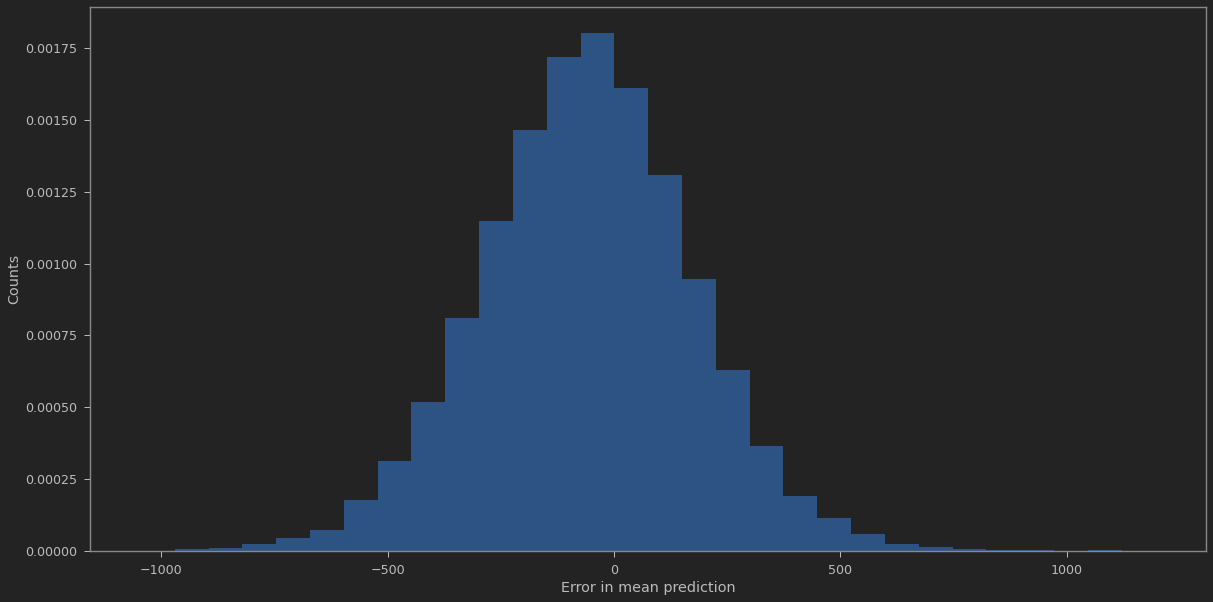

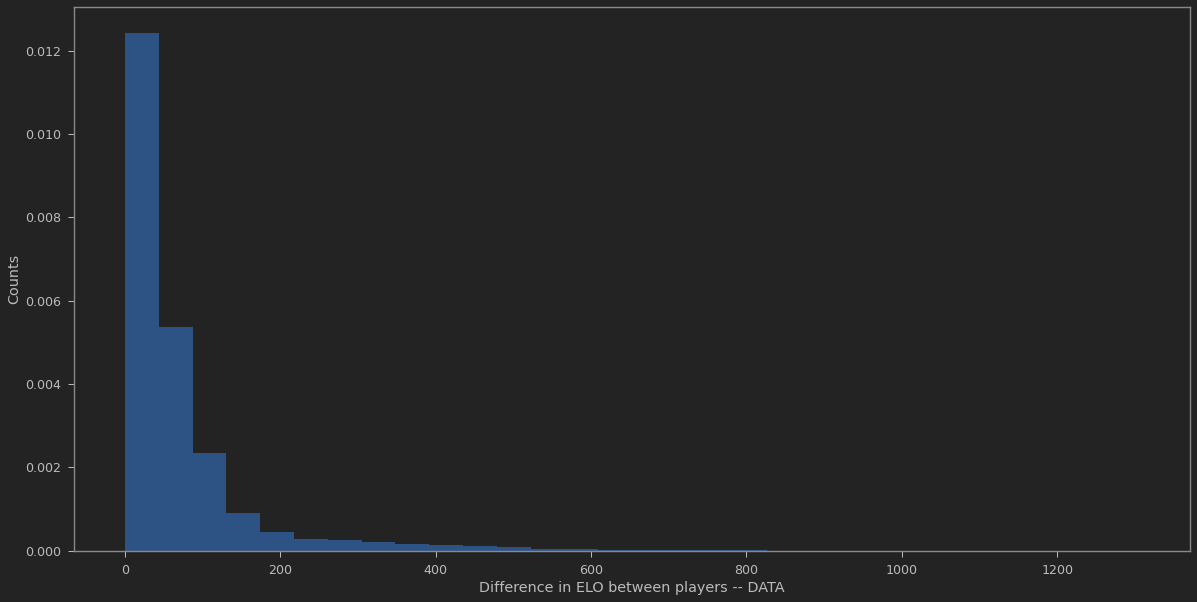

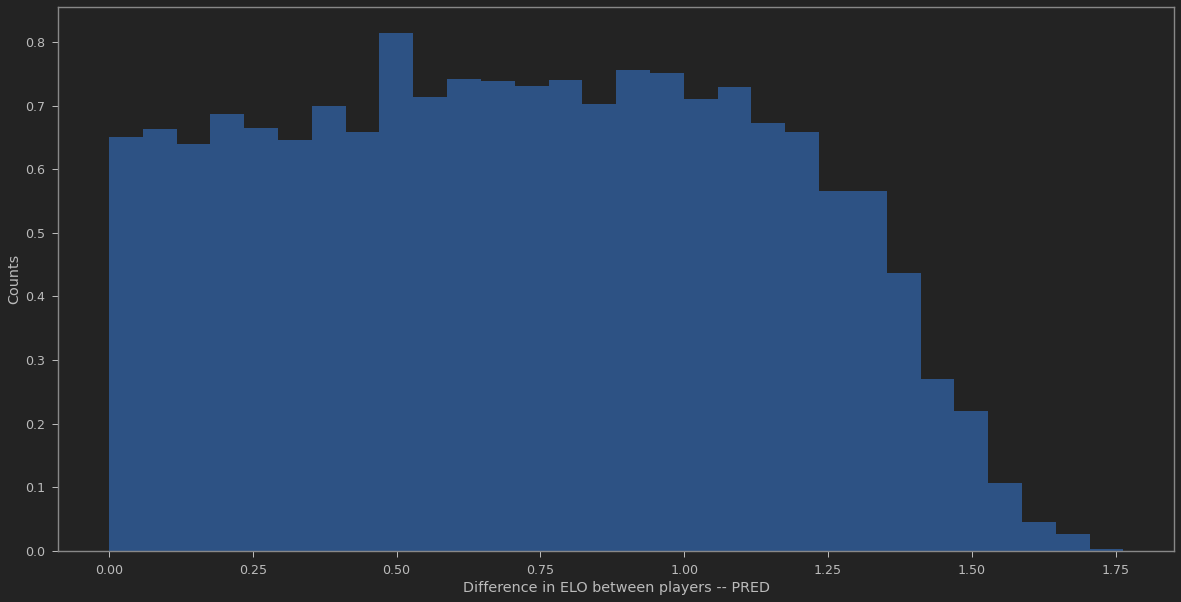

In [34]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

fig = plt.subplots(1,1,figsize=(20,10))
plt.hist(np.mean(test_truth.numpy(), axis=1) - np.mean(test_preds.numpy(), axis=1), bins=30, alpha=.6, density=True)
plt.xlabel('Error in mean prediction')
plt.ylabel('Counts')
plt.show()

fig = plt.subplots(1,1,figsize=(20,10))
plt.hist(np.abs((test_truth[:,0] - test_truth[:,1]).numpy()), bins=30, alpha=.6, density=True)
plt.xlabel('Difference in ELO between players -- DATA')
plt.ylabel('Counts')
plt.show()

fig = plt.subplots(1,1,figsize=(20,10))
plt.hist(np.abs((test_preds[:,0] - test_preds[:,1]).numpy()), bins=30, alpha=.6, density=True)
plt.xlabel('Difference in ELO between players -- PRED')
plt.ylabel('Counts')
plt.show()

## Summary

Our model achieves an MAE of 194 ELO on out of sample data. It is worth emphasizing that we do not expect a perfect predictor to exist -- player performance has varies largely game-to-game, however player ELO is unresponsive to these fluctuations. Additionally, move order of course does not contain all information needed to predict player ELO. With these difficulties in mind, though, there is likely still room for improvement as our model is quite small (6 attention heads, 3 hidden layers) due to current limitations in computational resources.

Clearly, the model has issues predicting meaningful differences between the ELO of the white and black player. This is likely due to underfitting: the model is likely not complex enough to pick up on the positional dependencies which reveal which moves were made by which player. Training a larger model may prevent this. That being said, the average ELO predictions tend to be in the correct vacinity.